<center>
    
    The Fourier Transform
    
    Author: Daniel Coble
</center>

The Fourier Transform extracts the frequency components of a signal. It is a linear transformation which transforms a time-series signal into a vector representing each frequency. There are continuous-time and discrete-time versions of the Fourier Transform; we will focus on the discrete Fourier transform. Say we have a signal $x(t)$. It's discrete sampling takes $N$ samples over its period to produce a vector
$$ x = [x(0), x(\tau), x(2\tau),...,x((N-1)\tau)]^T $$
where $\tau = T/N$ is the sampling rate, and $T$ is the period of the signal. The discrete Fourier transform is defined as follows:
$$ X_k = \sum_{n=0}^{N-1}x_n\cdot e^{-\frac{2\pi i kn}{N}} $$
where $i$ is the imaginary unit.

Resources:

[MIT OpenCourseWare lecture 26](https://www.youtube.com/watch?v=M0Sa8fLOajA&list=PL49CF3715CB9EF31D&index=27)

[Wikipedia, Discrete Fourier Transform](https://en.wikipedia.org/wiki/Discrete_Fourier_transform)

Let's first code a Fourier transform according to the definition. 

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from math import exp

I = complex(0, 1)
N = 20
t = np.arange(0, N)

x = t*(t-10)*(t-20)/100
# Fourier transform
X = np.zeros(x.shape, dtype=complex)
for k in range(N):
    for n in range(N):
        X[k] += x[n]*np.exp(-2*np.pi*I*k*n/N)

# transform X into real sine and cosine components
Xsin = np.zeros((N//2))
Xcos = np.zeros((N//2))

for k in range(N//2):
    Xcos[k] = np.real(X[k] + X[-k])
    Xsin[k] = np.real(I*(X[k] - X[-k]))

# Do an inverse transform from the sine and cosine components.
# If you don't believe me that this is the right way to index for sine and cosine: prove it to yourself.
x_reconstructed = np.zeros(N)
for k in range(N//2):
    x_reconstructed += 1/N*(Xcos[k]*np.cos(2*np.pi*k*t/N) + Xsin[k]*np.sin(2*np.pi*k*t/N))

Now let's make some plots. As we can see, `x` and `x_reconstruced` are identical.

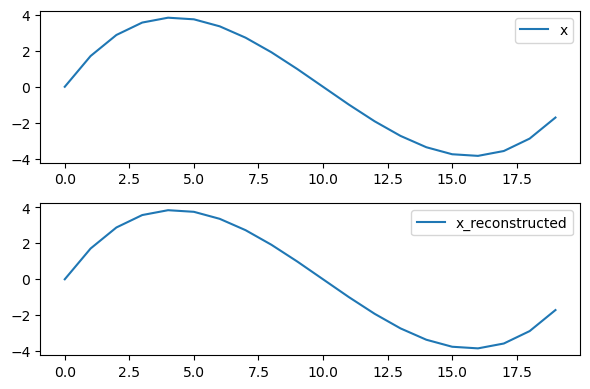

In [3]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(6,4))
ax1.plot(x, label='x')
ax1.legend()
ax2.plot(x_reconstructed, label='x_reconstructed')
ax2.legend()
plt.tight_layout()

We can examine the sine and cosine components of the signal. Why is the cosine component zero? Why does sine peak at frequency=1?

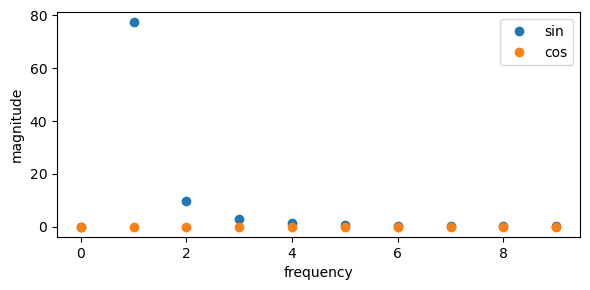

In [4]:
plt.figure(figsize=(6,3))
plt.plot(Xsin, marker='o', linewidth=0, label='sin')
plt.plot(Xcos, marker='o', linewidth=0, label='cos')
plt.ylabel('magnitude')
plt.xlabel('frequency')
plt.legend()
plt.tight_layout()

As you may have noticed, the definition of the DFT is a linear transformation and can be described by a matrix. The Fourier matrix is described by
$$ F_{jk} = \exp\left(\frac{-2\pi ijk}{N}\right)$$
In the first example, we decomposed a signal into a sum of sines and cosines of different frequencies. Most times, its more useful to represent the signal as one sinusoid with a phase shift. That's done with the following trig identity:
$$ a\cos(x) + b\sin(x) = \left(\sqrt{a^2+b^2}\right)\cos\left(x-\arctan\left(\frac{b}{a}\right)\right)$$
So if $X_{\cos}$ and $X_{\sin}$ are the coefficients from the cosine and sine transform, we can create the new quantities to represent amplitude and phase shift of each frequency:
$$ A_k = \sqrt{X_{\cos,k}^2 + X_{\sin,k}^2} $$
$$ \phi_k = -\arctan{\left(\frac{X_{\sin,k}}{X_{\cos,k}}\right)} $$
Of these two, $A_k$ is much more important as it represents the energy of the signal at each frequency (Specifically, $A_k^2$ is proportional to energy).

Now let's do a bigger example by building the Fourier transform matrix for a larger signal with $N=128$. For the dataset, we'll use a finite-element simulation of a beam which I created for a different project. For added realism, I've also added some noise. 

In [5]:
# Construct the DFT matrix.
N = 128 # length of the signal

I = complex(0, 1)

F = np.zeros((N, N), dtype=np.cdouble)
for j in range(N):
    for k in range(N):
        F[j,k] = np.exp(-2*np.pi*I*j*k/N)

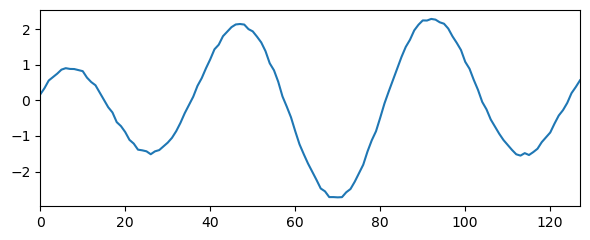

In [6]:
# load data. The shape of the data is [time, nodes]
x_fea = np.load('./data/x_fea.npy')
# Take the midpoint node, and first 128 datapoints.
x = x_fea[:N,20]
# Plot this data. It's important that it's periodic over 128 samples.
plt.figure(figsize=(6,2.5))
plt.plot(x)
plt.xlim((0,x.size-1))
plt.tight_layout()

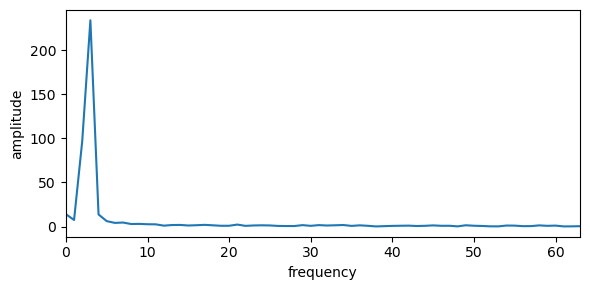

In [7]:
# Do the Fourier transform.
X = F@x

# transform X into real sine and cosine components
Xsin = np.zeros((N//2))
Xcos = np.zeros((N//2))

for k in range(N//2):
    Xcos[k] = np.real(X[k] + X[-k])
    Xsin[k] = np.real(I*(X[k] - X[-k]))

A = np.sqrt(Xcos**2 + Xsin**2)
phi = -np.arctan(Xsin/Xcos)

# Plot the amplitude profile.
plt.figure(figsize=(6,3))
plt.plot(A)
plt.xlabel('frequency')
plt.ylabel('amplitude')
plt.xlim((0,A.size-1))
plt.tight_layout()

As you can see, all the interesting stuff happens at the lower frequencies. You can try remaking the plot, only including the first few frequencies. Also, try plotting $\phi_k$. Does it look like it has anything interesting?

For signals on the order of $N$ in the hundreds (or on modern machines, low thousands), it's feasible to use the matrix version of the FT. However, for big signals, we have to use an algorithm called the fast Fourier transform (FFT). To show an FFT, let's use the FEA dataset again, but take a much larger section. The FFT algorithm is particularly efficient when $N$ is a power of 2, so we'll use $N=8196=2^{13}$. The `scipy.fft` package provides an implementation of the FFT.

p.s. The history of the FFT is very interesting. See [this video](https://www.youtube.com/watch?v=nmgFG7PUHfo) by the YouTube channel Veritasium.

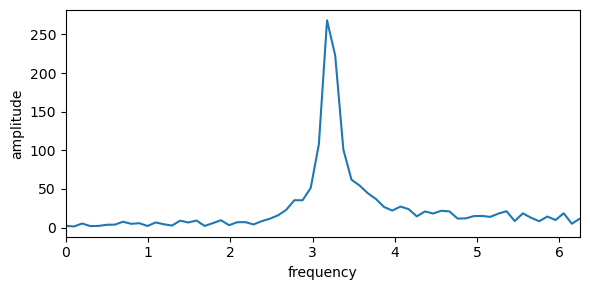

In [8]:
import numpy as np
from scipy.fft import fft, fftfreq

# When taking long time samples, it's less important that the data be exactly periodic.
x = x_fea[:2**13,20]
# For our purposes, let's say that the sample was over 10 seconds. Then the fftfreq will return frequencies in terms of seconds.
t = np.linspace(0, 10, N)
T = t[1]-t[0] # sample spacing
X = fft(x)
freq = fftfreq(N,T)[:N//2]

for k in range(N//2):
    Xcos[k] = np.real(X[k] + X[-k])
    Xsin[k] = np.real(I*(X[k] - X[-k]))

A = np.sqrt(Xcos**2 + Xsin**2)

# Plot the amplitude profile.
plt.figure(figsize=(6,3))
plt.plot(freq, A)
plt.xlabel('frequency')
plt.ylabel('amplitude')
plt.xlim((freq[0], freq[-1]))
plt.tight_layout()

**Challenge problem**

Generally, higher frequencies of a signal are less interesting than the lower frequencies. In structural systems, higher frequency modes impact a structure less, and in a sensor, a high frequency signal is likely to be noise. Below, I create a 2000-point signal as the sum of a sine with frequency of 20 and a sine with frequency of 200. For realism, I've also added some noise. Remove the high frequency component by doing the following: perform a Fourier transform, then set all components with frequency greater than 100 to zero. Then perform an inverse Fourier transform. Plot the two signals to see that you removed the high-frequency component. You can choose to use either the matrix-version of the FT or the `scipy` version. If you use the matrix, it may be useful to note that the FT has the nice property $F^{-1}=(1/N)F^\dagger$ ($\dagger$ represents the complex conjugate). If you use `scipy`, the inverse FFT function is `scipy.fft.ifft`.

In [9]:
t = np.linspace(0, 1, num=2000) # say the signal occurs over 1 sec.
x = np.sin(2*np.pi*(20*t)) + .2*np.sin(2*np.pi*(200*t)) + (.05*np.random.rand(2000)-.025)